In [49]:
!cat /etc/*-release #info about the os version

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.2 LTS"
NAME="Ubuntu"
VERSION="18.04.2 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.2 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [50]:
!pip install gputil
!pip install psutil
!pip install humanize

import GPUtil as GPU
import os
import humanize
import psutil

!ln - sf / opt/bin/nvidia-smi / usr/bin/nvidia-smi

GPUs = GPU.getGPUs()
gpu= GPUs[0]

def printer():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available),
          " | Proc size: " + humanize.naturalsize(process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(
        gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    
   
printer()  
#checking alloted gpu by colab

ln: target 'usr/bin/nvidia-smi' is not a directory
Gen RAM Free: 10.7 GB  | Proc size: 3.4 GB
GPU RAM Free: 14014MB | Used: 1065MB | Util   7% | Total 15079MB


In [51]:
!nvidia-smi

Thu Jul 25 07:54:58 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |   1065MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [52]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [53]:
!pip3 install torch torchvision

In [54]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
!pip install gdown

# create directory for storing data
!mkdir -p data

# download zip file with training set
!gdown https://drive.google.com/uc?id=1z_vO2muBgzNGIa7JtY8OPmaeUC348jj4 && unzip -qq training_set.zip -d data/training_set
!rm training_set.zip

# download zip with test set
!gdown https://drive.google.com/uc?id=1ziwxAVrbDRfUTYMrFu0sn1B8OH-6gvej && unzip -qq test_set.zip -d data/test_set
!rm test_set.zip

# remove some leftover dir
!rm -r /content/data/test_set/__MACOSX/

# change dir to the one with data 
!cd /content/data

Downloading...
From: https://drive.google.com/uc?id=1z_vO2muBgzNGIa7JtY8OPmaeUC348jj4
To: /content/training_set.zip
174MB [00:01, 129MB/s]
replace data/training_set/wario/wario_2822.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Downloading...
From: https://drive.google.com/uc?id=1ziwxAVrbDRfUTYMrFu0sn1B8OH-6gvej
To: /content/test_set.zip
43.4MB [00:00, 47.3MB/s]
replace data/test_set/wario/wario_3296.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import os

def restart_runtime():
  os.kill(os.getpid(), 9)
  
restart_runtime()

In [1]:
import os
import shutil
import numpy as np
import time
from collections import OrderedDict

from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torchvision import datasets,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print('Cuda Available')
  pin_memory= True

Cuda Available


In [0]:
def imshow(img):
    '''
    Helper function to un-normalize and display an image
    
    Input:
    img - tensor
    '''
    
    # move to CPU in case working on GPU
    if type(img) is not np.ndarray:
        if 'cuda' in img.type():
            img = img.cpu()
        
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
def pretty_cm(y_pred, y_truth, labels):
    '''
    'Pretty' implementation of a confusion matrix with some evaluation stat.
    
    Input:
    y_pred - object with class predictions from the model
    y_truth - object with actual classes
    labels - list containing label names
    '''
    
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, 
                cmap = 'BuGn_r')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Confusion Matrix', size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    print('#######################')
    print('Evaluation metrics ####')
    print('#######################')
    print('Accuracy: {:.4f}'.format(metrics.accuracy_score(y_truth, y_pred)))
    print('Precision: {:.4f}'.format(metrics.precision_score(y_truth, y_pred)))
    print('Recall: {:.4f}'.format(metrics.recall_score(y_truth, y_pred)))
    print('F1: {:.4f}'.format(metrics.f1_score(y_truth, y_pred)))

In [0]:
num_workers = 0
batch_size =32
valid_size = 0.2

image_transforms = transforms.Compose([transforms.Resize((128,128)),
                                       transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5),
                                                           (0.5,0.5, 0.5))])

train_data = datasets.ImageFolder(root='data/training_set', 
                                  transform = image_transforms)
test_data = datasets.ImageFolder(root='data/test_set', 
                                 transform = image_transforms)



In [0]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [0]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size = batch_size,
                                          sampler = train_sampler,
                                          num_workers = num_workers,
                                          pin_memory = pin_memory)

test_loader = torch.utils.data.DataLoader(test_data,
                                          shuffle = True,
                                          batch_size = batch_size,
                                          num_workers = num_workers,
                                          pin_memory = pin_memory)

valid_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size = batch_size,
                                          sampler = valid_sampler,
                                          num_workers = num_workers,
                                          pin_memory = pin_memory)

classes = ['mario', 'wario']



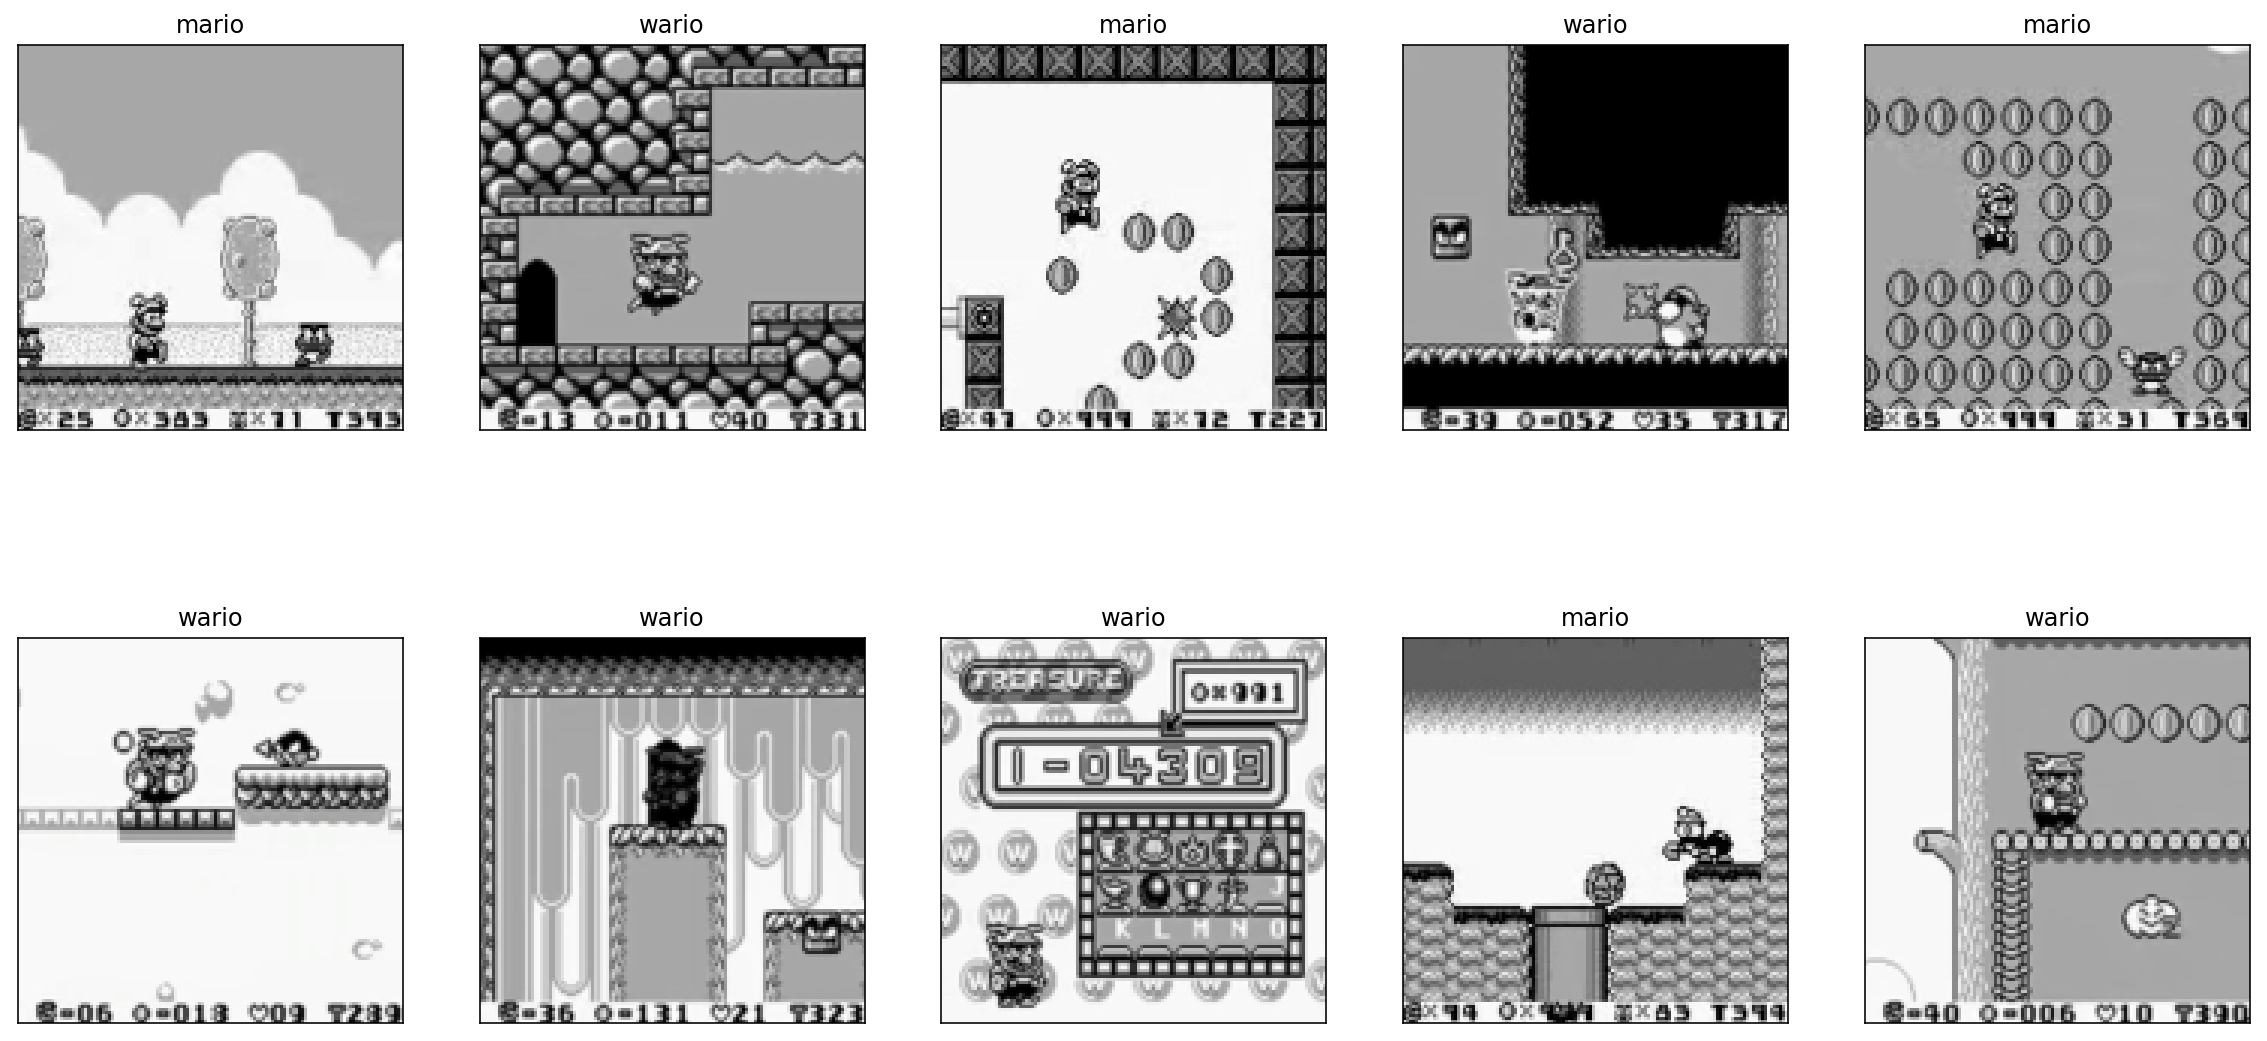

In [7]:
dataiter = iter(train_loader)
data, target = dataiter.next()
data = data.numpy()

fig = plt.figure(figsize = (20,10))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
  imshow(data[idx])
  ax.set_title(classes[target[idx]])
  
  

In [8]:
class Flatten(nn.Module):
  def forward(self,x):
    return x.view(x.size()[0], -1)
  
model = nn.Sequential(OrderedDict([
    ('con_1', nn.Conv2d(3, 16, 3, padding =1)),
    ('relu_1', nn.ReLU()),
    ('max_pool_1', nn.MaxPool2d(2, 2)),
    ('conv_2', nn.Conv2d(16, 32, 3, padding=1)),
    ('relu_2', nn.ReLU()),
    ('max_pool_2', nn.MaxPool2d(2, 2)),
    ('conv_3', nn.Conv2d(32, 64, 3, padding=1)),
    ('relu_3', nn.ReLU()),
    ('max_pool_3', nn.MaxPool2d(2, 2)),
    ('flatten', Flatten()),
    ('dropout_1', nn.Dropout(0.25)),
    ('fc_1', nn.Linear(64 * 16 * 16, 128)),
    ('relu_4', nn.ReLU()),
    ('dropout', nn.Dropout(0.25)),
    ('fc_2', nn.Linear(128, 1))
    
]))

print(model)

Sequential(
  (con_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (max_pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (dropout_1): Dropout(p=0.25)
  (fc_1): Linear(in_features=16384, out_features=128, bias=True)
  (relu_4): ReLU()
  (dropout): Dropout(p=0.25)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
)


In [0]:
if train_on_gpu:
  model.cuda()

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

In [0]:
def train_cnn(model, train_loader, valid_loader, criterion, optimizer,
              n_epochs = 30, 
              train_on_gpu = False, save_model = True, plot_loss = True):
  valid_loss_min = np.Inf;
  train_losses, valid_losses = [], []
  times=[]
  
  for epoch in range(1, n_epochs+1):
    
    train_loss=0.0
    valid_loss=0.0
    
    if train_on_gpu:
      torch.cuda.synchronize()
    t0= time.perf_counter()
    
    model.train()
    for data, target in train_loader:
      
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        
      if((type(criterion) == torch.nn.modules.loss.BCEWithLogitsLoss) 
         and (target.type()== 'torch.cuda.LongTensor')
         and train_on_gpu ):
        target = target.type(torch.cuda.FloatTensor)
      else:
        target = target.type(torch.FloatTensor)
        
      
      optimizer.zero_grad()
      
      output = model(data).squeeze()
      
      loss = criterion(output, target)
      
      loss.backward()
      
      optimizer.step()
      
      train_loss += loss.item()*data.size(0)
      
    
    with torch.no_grad():
      model.eval()
      for data, target in valid_loader:
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
          
        if((type(criterion) == torch.nn.modules.loss.BCEWithLogitsLoss) 
         and (target.type()== 'torch.cuda.LongTensor')
         and train_on_gpu ):
          target = target.type(torch.cuda.FloatTensor)
        else:
          target = target.type(torch.FloatTensor)
          
        output = model(data).squeeze()
        
        loss = criterion(output, target)
        
        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.dataset)
    train_losses.append(train_loss)
    
    valid_loss = valid_loss/len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    
    if train_on_gpu:
      torch.cuda.synchronize()
    t1 = time.perf_counter()
    times.append(t1 - t0)
    
    print('Epoch: {} | Training Loss: {:.7f} | Validation Loss:{:.7f} | Training Time: {:.3f} s' .format(
          epoch, train_loss, valid_loss, t1-t0))
    
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.7f} to {:.7f})'. format(
      valid_loss_min,
      valid_loss))
      torch.save(model.state_dict(), 'model_mvw_' + str(epoch)+ '.pt')
      valid_loss_min = valid_loss
      
  if plot_loss:
    plt.plot(train_losses, label = 'Training Loss')
    plt.plot(valid_losses, label = 'Validation Loss')
    plt.legend(frameon = False)
    
  return model
    
      
  

Epoch: 1 | Training Loss: 0.5367609 | Validation Loss:0.1267630 | Training Time: 21.198 s
Validation loss decreased (inf to 0.1267630)
Epoch: 2 | Training Loss: 0.3790854 | Validation Loss:0.0275057 | Training Time: 21.044 s
Validation loss decreased (0.1267630 to 0.0275057)
Epoch: 3 | Training Loss: 0.0569541 | Validation Loss:0.0064061 | Training Time: 21.115 s
Validation loss decreased (0.0275057 to 0.0064061)
Epoch: 4 | Training Loss: 0.0293578 | Validation Loss:0.0052611 | Training Time: 20.794 s
Validation loss decreased (0.0064061 to 0.0052611)
Epoch: 5 | Training Loss: 0.0209746 | Validation Loss:0.0055984 | Training Time: 20.838 s
Epoch: 6 | Training Loss: 0.0184252 | Validation Loss:0.0034762 | Training Time: 20.716 s
Validation loss decreased (0.0052611 to 0.0034762)
Epoch: 7 | Training Loss: 0.0134959 | Validation Loss:0.0038835 | Training Time: 20.620 s
Epoch: 8 | Training Loss: 0.0122584 | Validation Loss:0.0029871 | Training Time: 20.537 s
Validation loss decreased (0.00

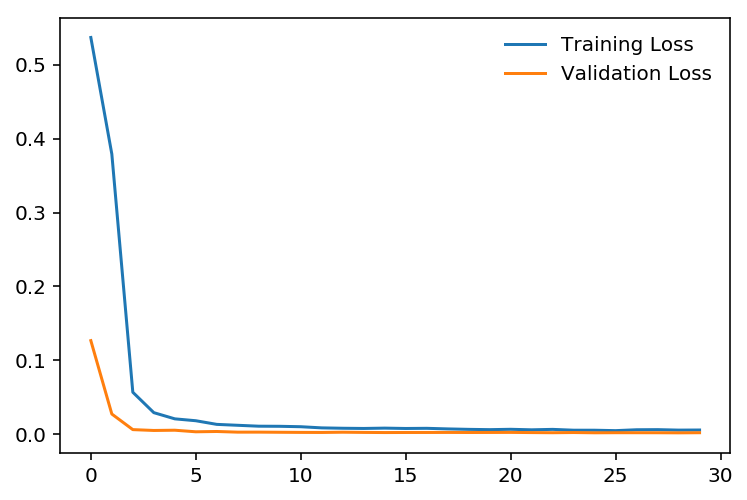

In [11]:
model = train_cnn(model, train_loader, valid_loader, criterion, optimizer, n_epochs=30, train_on_gpu = True)

In [12]:
#using model 12

model.load_state_dict(torch.load('model_mvw_12.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [13]:
f_sigmoid = nn.Sigmoid()

test_loss=0.0

incorrect_images = []
true_label = []
incorrect_label = []


y_true =[]
y_pred=[]

model.eval()

with torch.no_grad():
  for data, target in test_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
      
    if ((type(criterion) == torch.nn.modules.loss.BCEWithLogitsLoss)
           and (target.type() == 'torch.cuda.LongTensor')
           and train_on_gpu):
            target = target.type(torch.cuda.FloatTensor)
            target_byte = target.type(torch.cuda.ByteTensor)
    elif ((type(criterion) == torch.nn.modules.loss.BCEWithLogitsLoss) and 
             (target.type() == 'torch.LongTensor')):
            target = target.type(torch.FloatTensor)
            target_byte = target.type(torch.ByteTensor)
          
    output = model(data).squeeze()
    
    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)
    
    pred_prob = f_sigmoid(output)
    
    pred = pred_prob >=0.5
    
    y_true.extend(target.type(torch.ByteTensor).data.view_as(pred).numpy().tolist()
                  if not train_on_gpu 
                  else np.squeeze(target.type(torch.ByteTensor).data.view_as(pred).cpu().numpy().tolist()))
    y_pred.extend(pred.numpy().tolist() 
                  if not train_on_gpu 
                  else np.squeeze(pred.cpu().numpy().tolist()))
    
    if train_on_gpu:
      to_compare = target.type(torch.cuda.ByteTensor).data.view_as(pred)
      
    else:
      to_compare = target.type(torch.ByteTensor).data.view_as(pred)
      
    correct_tensor = pred.eq(to_compare)
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(min(data.shape[0], batch_size)):
      
      if correct[i].item() == 0:
        incorrect_images.append(data[i])
        true_label.append(int(target.data[i].item()))
        incorrect_label.append(pred[i].item())
        
incorrect_images = torch.stack(incorrect_images, 0)

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss:  {:.7f} \n'.format(test_loss))
    

Test Loss:  0.0169583 



#######################
Evaluation metrics ####
#######################
Accuracy: 0.9945
Precision: 0.9940
Recall: 0.9950
F1: 0.9945


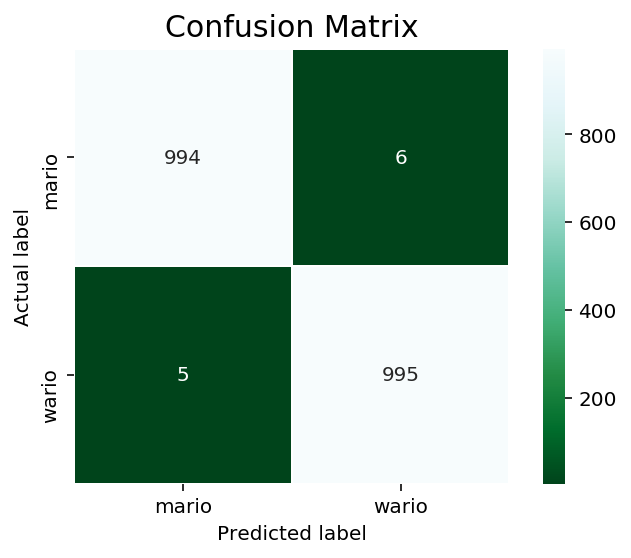

In [14]:
pretty_cm(y_pred, y_true, classes)

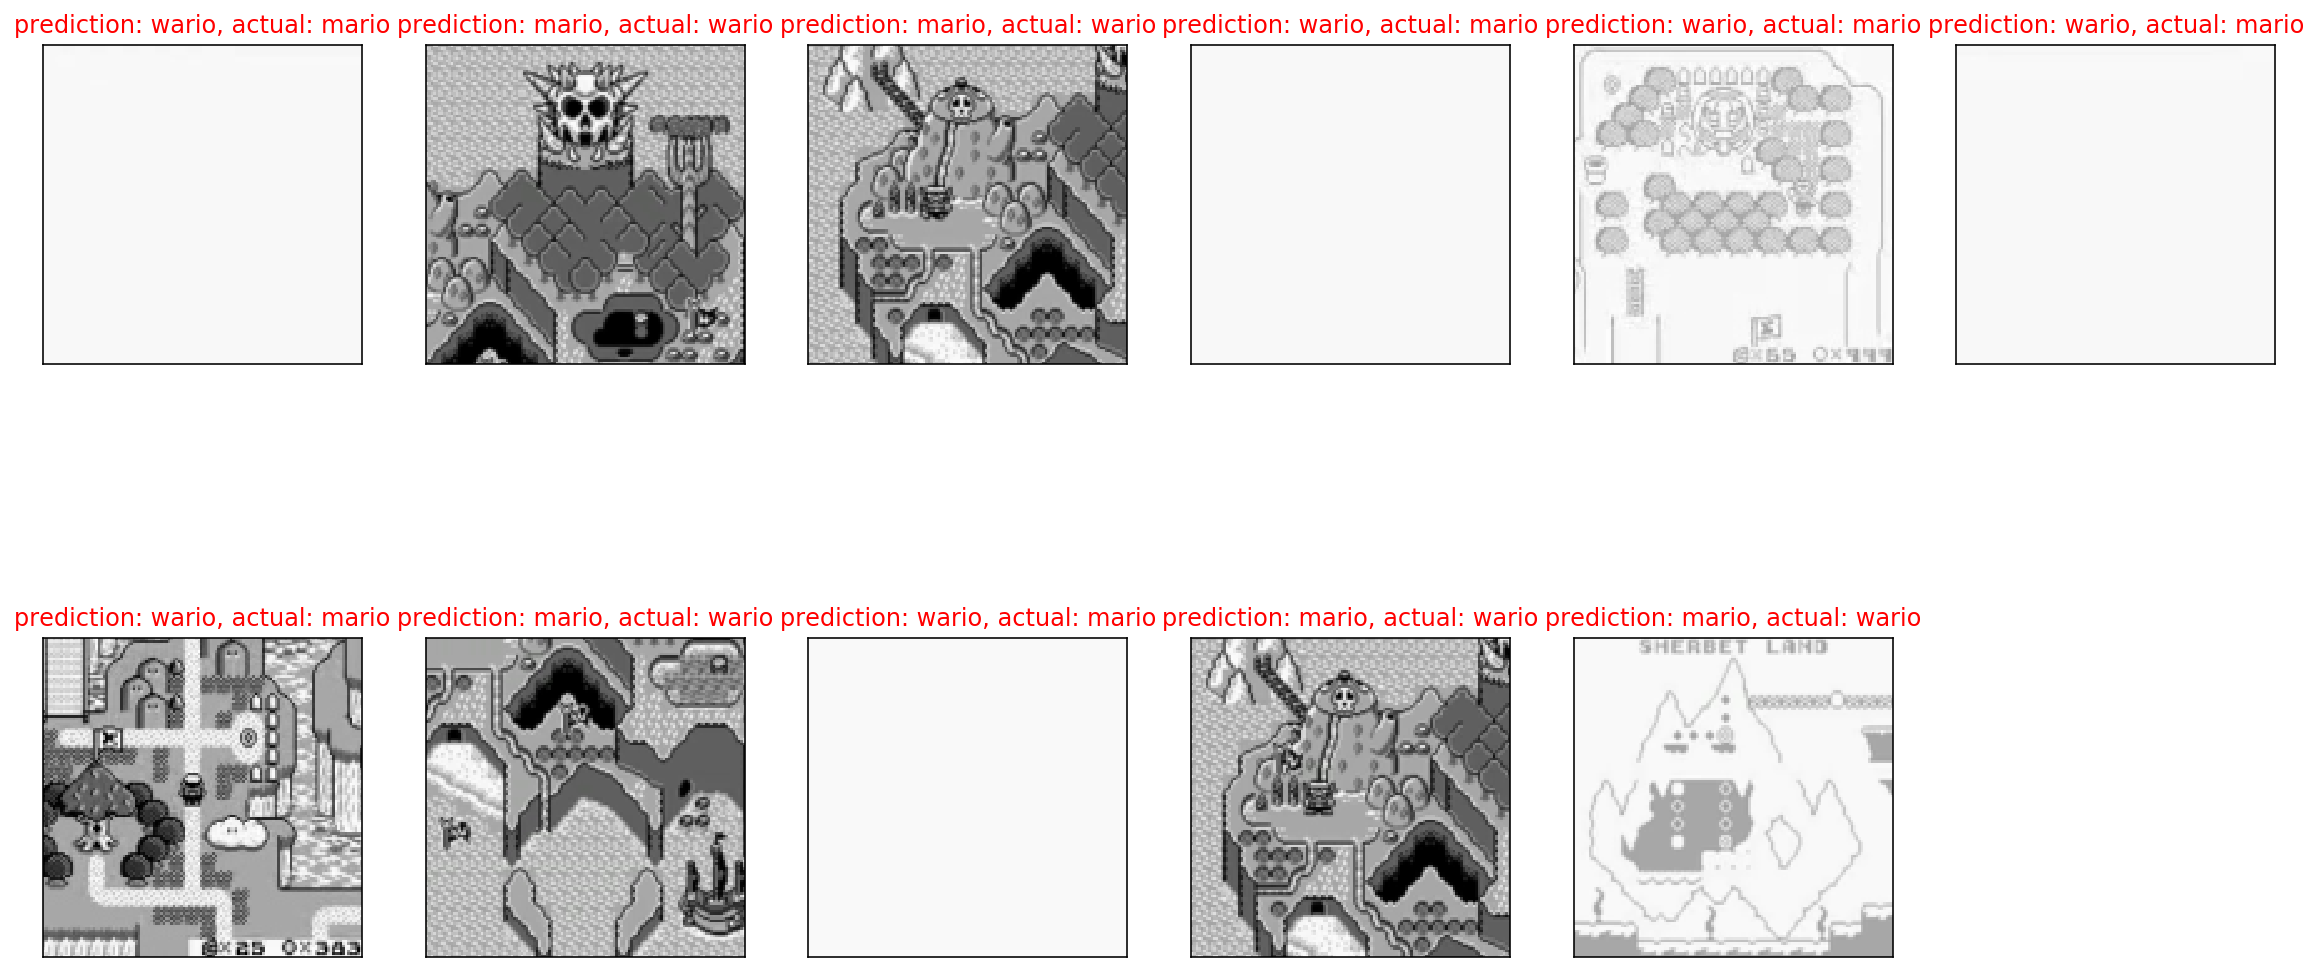

In [15]:
# inspect the incorrectly classified images
fig = plt.figure(figsize=(20, 10))
for idx in np.arange(11):
    ax = fig.add_subplot(2, 12/2, idx+1, xticks=[], yticks=[])
    imshow(incorrect_images[idx])
    ax.set_title("prediction: {}, actual: {}".format(classes[incorrect_label[idx]], classes[true_label[idx]]),
                 color=("green" if incorrect_label[idx]==true_label[idx] else "red"))